# Estimation of effective connectivity using MOU process (MOU-EC)

This Python notebook estimates a matrix of MOU-EC for each fMRI session. The dataset comprises 22 subjects with 5 sessions each (2 for resting-state and 3 for movie, with distinct parts of the movie).

In [1]:
import os
import numpy as np
import scipy.signal as spsg
import MOUmodel
import matplotlib.pyplot as pp

os.system('clear')

res_dir = 'model_param/'
if not os.path.exists(res_dir):
    print('create directory:',res_dir)
    os.makedirs(res_dir)


## Dataset

shape of data array: (22, 5, 66, 300)


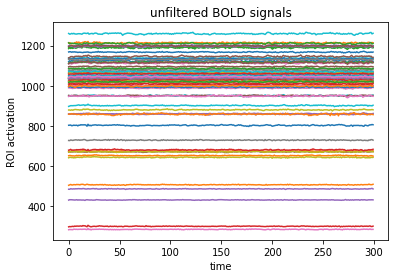

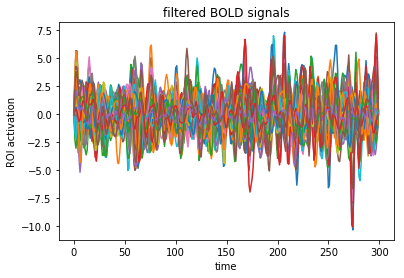

In [29]:
#################
# fMRI properties    
n_sub = 22 # number of subjects
n_run = 5 # first 2 rest + last 3 movie
N = 66 # number of ROIs
T = 300 # number of TRs of the recording


#################
# functional data
ts_emp = np.load('ts_emp.npy')
print('shape of data array:', ts_emp.shape)

# filtering between 0.01 and 0.1 Hz
n_order = 3
Nyquist_freq = 0.5 / 2.
low_f = 0.01 / Nyquist_freq
high_f = 0.1 / Nyquist_freq
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')

filtered_ts_emp = np.zeros(ts_emp.shape)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        for i in range(N):
            filtered_ts_emp[i_sub,i_run,i,:] = spsg.filtfilt(b,a,ts_emp[i_sub,i_run,i,:])

# plots
pp.figure()
pp.plot(range(T),ts_emp[0,0,:,:].T)
pp.xlabel('time')
pp.ylabel('ROI activation')
pp.title('unfiltered BOLD signals')

pp.figure()
pp.plot(range(T),filtered_ts_emp[0,0,:,:].T)
pp.xlabel('time')
pp.ylabel('ROI activation')
pp.title('filtered BOLD signals')

pp.show()

In [30]:
ROI_labels = np.load('ROI_labels.npy')
print('original order:\n', ROI_labels)

# reorder ROIs with inverse order for the two hemispheres
new_ind = np.zeros([N],dtype=np.int)
new_ind[:int(N/2)] = np.arange(int(N/2))
new_ind[int(N/2):] = N - 1 - np.arange(int(N/2))
#print(new_ind)

ROI_labels = ROI_labels[new_ind]
filtered_ts_emp = filtered_ts_emp[:,:,new_ind,:]
print('new order:\n', ROI_labels)



original order:
 ['rBSTS' ' rCAC' ' rCMF' ' rCUN' ' rENT' '  rFP' ' rFUS' '  rIP' '  rIT'
 'rISTC' 'rLOCC' ' rLOF' 'rLING' ' rMOF' '  rMT' 'rPARC' 'rPARH' 'rPOPE'
 'rPORB' 'rPTRI' 'rPCAL' 'rPSTC' '  rPC' 'rPREC' 'rPCUN' ' rRAC' ' rRMF'
 '  rSF' '  rSP' '  rST' 'rSMAR' '  rTP' '  rTT' 'lBSTS' ' lCAC' ' lCMF'
 ' lCUN' ' lENT' '  lFP' ' lFUS' '  lIP' '  lIT' 'lISTC' 'lLOCC' ' lLOF'
 'lLING' ' lMOF' '  lMT' 'lPARC' 'lPARH' 'lPOPE' 'lPORB' 'lPTRI' 'lPCAL'
 'lPSTC' '  lPC' 'lPREC' 'lPCUN' ' lRAC' ' lRMF' '  lSF' '  lSP' '  lST'
 'lSMAR' '  lTP' '  lTT']
new order:
 ['rBSTS' ' rCAC' ' rCMF' ' rCUN' ' rENT' '  rFP' ' rFUS' '  rIP' '  rIT'
 'rISTC' 'rLOCC' ' rLOF' 'rLING' ' rMOF' '  rMT' 'rPARC' 'rPARH' 'rPOPE'
 'rPORB' 'rPTRI' 'rPCAL' 'rPSTC' '  rPC' 'rPREC' 'rPCUN' ' rRAC' ' rRMF'
 '  rSF' '  rSP' '  rST' 'rSMAR' '  rTP' '  rTT' '  lTT' '  lTP' 'lSMAR'
 '  lST' '  lSP' '  lSF' ' lRMF' ' lRAC' 'lPCUN' 'lPREC' '  lPC' 'lPSTC'
 'lPCAL' 'lPTRI' 'lPORB' 'lPOPE' 'lPARH' 'lPARC' '  lMT' ' lMOF' 'lLI

## Functional connectivity

In [34]:
# time shifts for FC: 0, 1 and 2 TR
v_tau = np.arange(3,dtype=float)
n_tau = v_tau.size

FC_emp = np.zeros([n_sub,n_run,n_tau,N,N]) # FC = spatiotemporal covariances of BOLD signals
for i_sub in range(n_sub):
    for i_run in range(n_run):
        # center the time series
        filtered_ts_emp[i_sub,i_run,:,:] -= np.outer(filtered_ts_emp[i_sub,i_run,:,:].mean(1),np.ones([T]))
        # calculate covariances with time shift
        for i_tau in range(n_tau):
            FC_emp[i_sub,i_run,i_tau,:,:] = np.tensordot(filtered_ts_emp[i_sub,i_run,:,0:T-n_tau+1],filtered_ts_emp[i_sub,i_run,:,i_tau:T-n_tau+1+i_tau],axes=(1,1)) / float((T-n_tau))

FC_emp *= 0.5/FC_emp[:,:2,0,:,:].diagonal(axis1=2,axis2=3).mean()

print('max FC value (most of the distribution should be between 0 and 1):',FC_emp.mean())

# show FC0 for first subject, first run (rest)
pp.imshow(FC_emp[0,0,0,:,:])
pp.xlabel('source ROI')
pp.ylabel('target ROI')
pp.title('FC0 (functional connectivity with no time lag)')

pp.show()

max FC value (most of the distribution should be between 0 and 1): 0.10476835339902639


## Structural connectivity

EC density: 0.27505827505827507


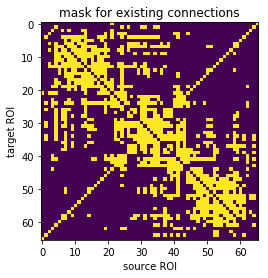

In [35]:
SC_anat = np.load('SC_anat.npy')

lim_SC = 0. # limit DTI value to determine SC (only connections with larger values are tuned)

# mask for existing connections for EC
mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC[SC_anat>lim_SC] = True
for i in range(N):
    mask_EC[i,i] = False # no self connection
    mask_EC[i,N-1-i] = True # additional interhemispheric connections
print('EC density:',mask_EC.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (here, no input cross-correlation)
mask_Sigma = np.eye(N,dtype=bool)

# plots
pp.figure()
pp.imshow(SC_anat)
pp.xlabel('source ROI')
pp.ylabel('target ROI')
pp.title('stuctural connectivity (DTI data)')

pp.figure()
pp.imshow(mask_EC)
pp.xlabel('source ROI')
pp.ylabel('target ROI')
pp.title('mask for existing connections')

pp.show()

## MOU-EC estimation

In [33]:
####################
# model optimization
J_mod = np.zeros([n_sub,n_run,N,N]) # Jacobian (off-diagonal elements = EC)
Sigma_mod = np.zeros([n_sub,n_run,N,N]) # local variance
dist_mod = np.zeros([n_sub,n_run]) # model error

for i_sub in range(n_sub):
    for i_run in range(n_run):
        print('sub',i_sub,'; run',i_run)

        # objective FC matrices (empirical)
        FC0_obj = FC_emp[i_sub,i_run,0,:,:]
        FC1_obj = FC_emp[i_sub,i_run,1,:,:]

        # time constant for BOLD autocovariances (calculated with lag from 0 to 2 TRs)
        ac_tmp = np.maximum(FC_emp[i_sub,i_run,:,:,:].diagonal(axis1=1,axis2=2),1e-6) # autocovariance for time shifts in v_tau; with lower bound to avoid negative values (cf. log)
        tau_x = -1. / np.polyfit(v_tau,np.log(np.maximum(ac_tmp,1e-4)).mean(1),1)[0] # inverse of negative slope of autocovariance over all ROIs

        # estimate model parameters for each session
        (J_mod_tmp,Sigma_mod_tmp,err_mod_tmp) = MOUmodel.optimize(FC0_obj,FC1_obj,tau_x,mask_EC,mask_Sigma)

        J_mod[i_sub,i_run,:,:] = J_mod_tmp
        Sigma_mod[i_sub,i_run,:,:] = Sigma_mod_tmp
        dist_mod[i_sub,i_run] = err_mod_tmp


# save results
np.save(res_dir+'FC_emp.npy',FC_emp) # empirical spatiotemporal FC
np.save(res_dir+'mask_EC.npy',mask_EC) # mask of optimized connections
np.save(res_dir+'mask_Sigma.npy',mask_Sigma) # mask of optimized Sigma elements

np.save(res_dir+'J_mod.npy',J_mod) # estimated Jacobian matrices (EC + inverse time constant on diagonal)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod) # estimated Sigma matrices
np.save(res_dir+'dist_mod.npy',dist_mod) # model error

NameError: name 'xxx' is not defined

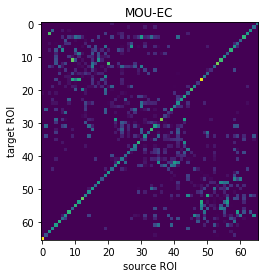

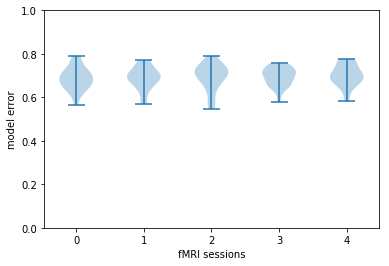

In [42]:
# display an exmaple MOU-EC matrix and the model error for all runs and subjects
pp.figure()
pp.imshow(np.maximum(J_mod[0,0,:,:],0))
pp.xlabel('source ROI')
pp.ylabel('target ROI')
pp.title('MOU-EC')

pp.figure()
pp.violinplot(dist_mod,positions=range(n_run))
pp.axis(ymin=0,ymax=1)
pp.xlabel('fMRI sessions')
pp.ylabel('model error')

pp.show()